In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyro
import pyro.distributions as dist
import zuko
from tqdm import tqdm
import deepwave
from deepwave import elastic
import IPython

sns.set(style="white", context="notebook", palette="deep", color_codes=True)

/home/cbd/src/mit/BayesAir/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Set up the deepwave elastic simulation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")  # TODO memory error on GPU

ny = 30
nx = 100
dx = 4.0

n_shots = 8

n_sources_per_shot = 1
d_source = 12
first_source = 8
source_depth = 2

n_receivers_per_shot = 9
d_receiver = 10
first_receiver = 0
receiver_depth = 2

freq = 15
nt = 100
dt = 0.004
peak_time = 1.5 / freq

# source_locations
source_locations = torch.zeros(
    n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device
)
source_locations[..., 0] = source_depth
source_locations[:, 0, 1] = torch.arange(n_shots) * d_source + first_source

# receiver_locations
receiver_locations = torch.zeros(
    n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device
)
receiver_locations[..., 0] = receiver_depth
receiver_locations[:, :, 1] = (
    torch.arange(n_receivers_per_shot) * d_receiver + first_receiver
).repeat(n_shots, 1)

# source_amplitudes
source_amplitudes = (
    (deepwave.wavelets.ricker(freq, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1)
    .to(device)
)

In [14]:
# Create a model mapping from the subsurface to the seismic data
# Use a coarser grid for the model than the simulation and normalize the latent params
x_downsample = 10
y_downsample = 3
nx_coarse = nx // x_downsample
ny_coarse = ny // y_downsample

vp_center = 1500
vp_scale = 100
vs_center = 1000
vs_scale = 100
rho_center = 2200
rho_scale = 100


def seismic_model(N, receiver_observations=None, observation_noise_scale=1e-1):
    # Define generic priors on a normalized basis
    profile = pyro.sample(
        "profile",
        dist.Normal(
            torch.zeros(ny_coarse, nx_coarse, device=device),
            1 * torch.ones(ny_coarse, nx_coarse, device=device),
        ),
    )
    vp = profile * vp_scale + vp_center
    vs = profile * vs_scale + vs_center
    rho = profile * rho_scale + rho_center

    # Upsample the model to the simulation grid
    vp = vp.repeat_interleave(y_downsample, dim=0).repeat_interleave(
        x_downsample, dim=1
    )
    vs = vs.repeat_interleave(y_downsample, dim=0).repeat_interleave(
        x_downsample, dim=1
    )
    rho = rho.repeat_interleave(y_downsample, dim=0).repeat_interleave(
        x_downsample, dim=1
    )

    # Run the simulation
    result = elastic(
        *deepwave.common.vpvsrho_to_lambmubuoyancy(vp, vs, rho),
        dx,
        dt,
        source_amplitudes_y=source_amplitudes,
        source_locations_y=source_locations,
        receiver_locations_y=receiver_locations,
        # pml_freq=freq,
        pml_width=[0, 20, 20, 20],
    )
    observed_data = result[-2]  # y amplitude receiver signals

    # Re-scale to a reasonable scale
    observed_data = observed_data * 1e7

    # Add noise to the observed data
    noise_dist = (
        dist.Normal(observed_data, observation_noise_scale).to_event(3).expand([N])
    )
    noisy_obs = pyro.sample(
        "receiver_observations",
        noise_dist,
        obs=receiver_observations,
    )
    return noisy_obs

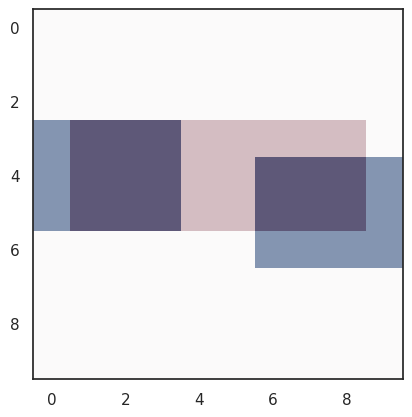

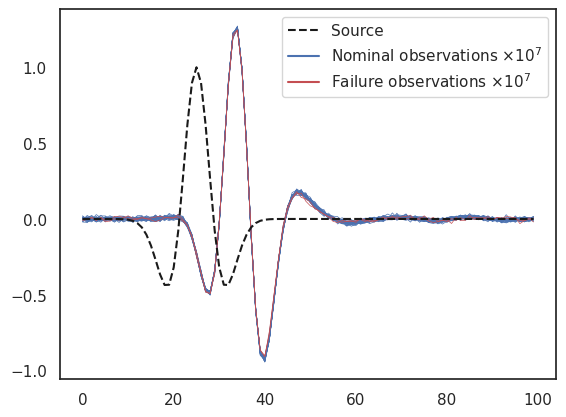

In [15]:
# Define the different subsurface conditions for "nominal" and "failure"
with torch.no_grad():
    profile_background = torch.zeros(ny_coarse, nx_coarse, device=device)

    # Nominal has a layer of higher vp, vs, and rho in the middle
    profile_nominal = profile_background.clone()
    profile_nominal[3:6, 1:9] = 1.0

    # Failure has a break in the middle of the layer
    profile_failure = profile_background.clone()
    profile_failure[3:6, 0:4] = 1.0
    profile_failure[4:7, 6:10] = 1.0

    plt.imshow(profile_nominal.cpu().numpy(), cmap="Reds", alpha=0.5)
    plt.imshow(profile_failure.cpu().numpy(), cmap="Blues", alpha=0.5)

    # Generate the data for the nominal and failure cases
    N_nominal = 25
    N_failure = 2
    observation_noise_scale = 1e-2

    nominal_model = pyro.poutine.condition(
        seismic_model, data={"profile": profile_nominal}
    )
    nominal_observations = nominal_model(
        N=N_nominal, observation_noise_scale=observation_noise_scale
    )

    failure_model = pyro.poutine.condition(
        seismic_model, data={"profile": profile_failure}
    )
    failure_observations = failure_model(
        N=N_failure, observation_noise_scale=observation_noise_scale
    )

plt.figure()
plt.plot(nominal_observations[:, 2, 4, :].cpu().numpy().T, "b-", linewidth=0.5)
plt.plot(failure_observations[:, 2, 4, :].cpu().numpy().T, "r-", linewidth=0.5)
plt.plot(source_amplitudes[0, 0, :].cpu().numpy(), "k--", label="Source")
plt.plot([], "b-", label="Nominal observations $\\times 10^7$")
plt.plot([], "r-", label="Failure observations $\\times 10^7$")
plt.legend()

In [16]:
# Define loss functions
def elbo_loss(model, guide, context, num_particles=10, *model_args, **model_kwargs):
    elbo = torch.tensor(0.0).to(context.device)
    guide_dist = guide(context)
    for _ in range(num_particles):
        posterior_sample, posterior_logprob = guide_dist.rsample_and_log_prob()

        # Reshape the sample
        posterior_sample = posterior_sample.reshape(ny_coarse, nx_coarse)

        model_trace = pyro.poutine.trace(
            pyro.poutine.condition(model, data={"profile": posterior_sample})
        ).get_trace(*model_args, **model_kwargs)
        model_logprob = model_trace.log_prob_sum()

        elbo += (model_logprob - posterior_logprob) / num_particles

    return -elbo  #  negative to make it a loss


def kl_divergence(p, q, p_contexts, q_contexts, num_particles=10):
    # Make sure contexts have a batch dimension
    if p_contexts.ndim == 1:
        p_contexts = p_contexts.unsqueeze(0)

    if q_contexts.ndim == 1:
        q_contexts = q_contexts.unsqueeze(0)

    # Make sure contexts have the same shape
    if p_contexts.shape != q_contexts.shape:
        raise ValueError("Contexts must have the same shape")

    p_dist = p(p_contexts)
    q_dist = q(q_contexts)

    p_samples, p_logprobs = p_dist.rsample_and_log_prob((num_particles,))
    q_logprobs = q_dist.log_prob(p_samples)

    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)

    return kl_divergence


def js_divergence(p, q, p_contexts, q_contexts, num_particles=10):
    # Make sure contexts have a batch dimension
    if p_contexts.ndim == 1:
        p_contexts = p_contexts.unsqueeze(0)

    if q_contexts.ndim == 1:
        q_contexts = q_contexts.unsqueeze(0)

    # Make sure contexts have the same shape
    if p_contexts.shape != q_contexts.shape:
        raise ValueError("Contexts must have the same shape")

    p_dist = p(p_contexts)
    q_dist = q(q_contexts)

    # Compute the KL divergence in both directions

    # Start from p to (p + q) / 2
    p_samples, p_logprobs = p_dist.rsample_and_log_prob((num_particles,))
    q_logprobs = q_dist.log_prob(p_samples)
    mixture_logprobs = torch.logsumexp(
        torch.stack([p_logprobs, q_logprobs]) - torch.log(torch.tensor(2.0)),
        dim=0,
    )
    kl_p_to_mixture = (p_logprobs - mixture_logprobs).mean(dim=0)

    # Now do the reverse
    q_samples, q_logprobs = q_dist.rsample_and_log_prob((num_particles,))
    p_logprobs = p_dist.log_prob(q_samples)
    mixture_logprobs = torch.logsumexp(
        torch.stack([p_logprobs, q_logprobs]) - torch.log(torch.tensor(2.0)),
        dim=0,
    )
    kl_q_to_mixture = (q_logprobs - mixture_logprobs).mean(dim=0)

    js_divergence = (kl_p_to_mixture + kl_q_to_mixture) / 2.0

    # Normalize to [0, 1]
    js_divergence /= torch.log(torch.tensor(2.0))

    return js_divergence

In [17]:
# Test the ELBO function
with torch.no_grad():
    flow = zuko.flows.NSF(
        features=nx_coarse * ny_coarse,
        context=1,
        transforms=2,
        hidden_features=(16, 16),
    ).to(device)
    context = torch.tensor([0.0], device=device)
    %time print(elbo_loss(seismic_model, flow, context, 10, N=N_nominal, receiver_observations=nominal_observations, observation_noise_scale=1e-2))

tensor(31038264., device='cuda:0')
CPU times: user 2.59 s, sys: 0 ns, total: 2.59 s
Wall time: 2.13 s


In [18]:
# Test the divergence functions
with torch.no_grad():
    flow1 = zuko.flows.NSF(
        features=3 * nx_coarse * ny_coarse,
        context=1,
        transforms=2,
        hidden_features=(16, 16),
    ).to(device)
    flow2 = zuko.flows.NSF(
        features=3 * nx_coarse * ny_coarse,
        context=1,
        transforms=2,
        hidden_features=(16, 16),
    ).to(device)
    context = torch.zeros(1, device=device)
    %time js_divergence(flow1, flow2, context, context, num_particles=100)

CPU times: user 1.92 s, sys: 271 ms, total: 2.19 s
Wall time: 1.84 s


In [19]:
# Define hyperparams
num_steps = 500
lr = 1e-3
grad_clip = torch.inf
weight_decay = 0.0
num_elbo_particles = 3
num_divergence_particles = 10
divergence_weight = 1e5
observation_noise_scale = 1e-3
elbo_weight = 1.0

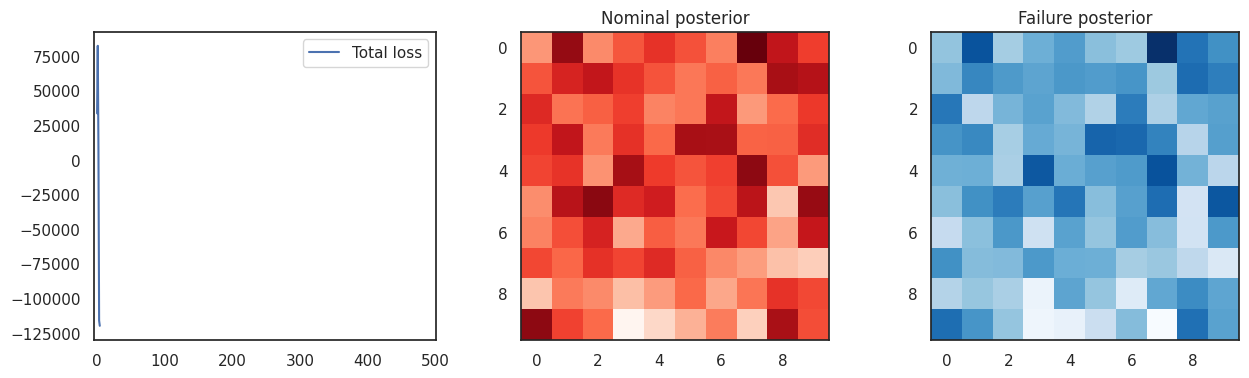

Step 4 | Nominal ELBO: -1.120e+05 | Failure ELBO: -7.836e+03 | JS deviation: 0.000e+00 | Loss: -1.198e+05 | Grad norm: 2.689e+05:   1%|▏              | 5/500 [00:49<1:22:21,  9.98s/it]


KeyboardInterrupt: 

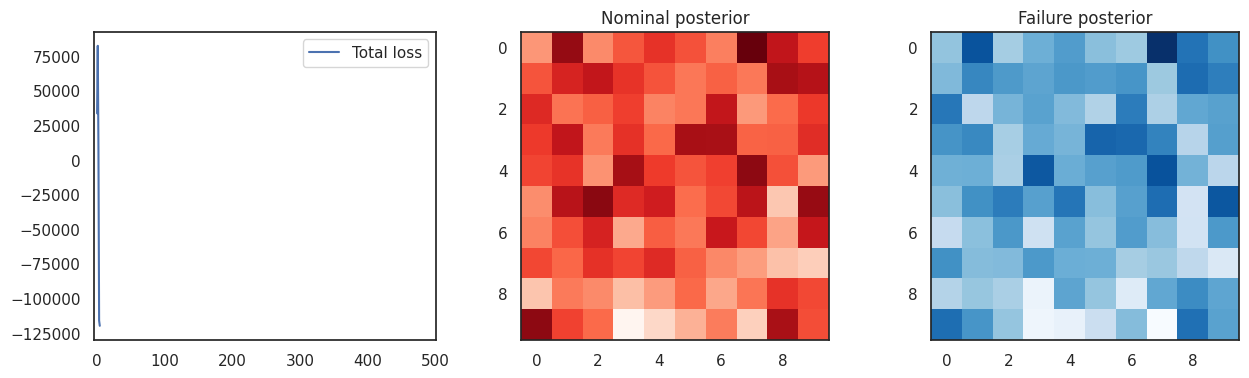

In [20]:
# Fit a combined nominal and failure posterior using a normalizing flow
flow = zuko.flows.NSF(
    features=nx_coarse * ny_coarse,
    context=1
).to(device)

optim = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)
nominal_elbo_losses = []
failure_elbo_losses = []
js_divergence_losses = []
total_losses = []

nominal_label = torch.tensor([0.0], device=device)
failure_label = torch.tensor([1.0], device=device)
divergence_bounds = torch.linspace(0.0, 1.0, 10).to(device)
nominal_context = torch.tensor([[0.0]] * 10).to(device)

pbar = tqdm(range(num_steps))
for step in pbar:
    optim.zero_grad()

    # Compute the loss components
    loss_components = {
        "nominal_elbo": elbo_loss(
            seismic_model,
            flow,
            nominal_label,
            num_elbo_particles,
            N=N_nominal,
            receiver_observations=nominal_observations,
        ),
        "failure_elbo": elbo_loss(
            seismic_model,
            flow,
            failure_label,
            num_elbo_particles,
            N=N_failure,
            receiver_observations=failure_observations,
        ),
        "js_divergence": js_divergence(
            flow,
            flow,
            nominal_context,
            divergence_bounds.reshape(-1, 1),
            num_divergence_particles,
        ),
    }
    loss_components["js_divergence_deviation"] = torch.nn.functional.relu(
        loss_components["js_divergence"] - divergence_bounds
    ).mean()
    loss = (
        elbo_weight * loss_components["nominal_elbo"]
        + elbo_weight * loss_components["failure_elbo"]
        + divergence_weight * loss_components["js_divergence_deviation"]
    )
    # Step the optimizer
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(flow.parameters(), grad_clip)
    optim.step()

    # Record the losses
    nominal_elbo_losses.append(loss_components["nominal_elbo"].detach().cpu().item())
    failure_elbo_losses.append(loss_components["failure_elbo"].detach().cpu().item())
    js_divergence_losses.append(
        loss_components["js_divergence_deviation"].detach().cpu().item()
    )
    total_losses.append(loss.detach().cpu().item())

    pbar.set_description(
        f"Step {step} | "
        f"Nominal ELBO: {nominal_elbo_losses[-1]:.3e} | "
        f"Failure ELBO: {failure_elbo_losses[-1]:.3e} | "
        f"JS deviation: {loss_components['js_divergence_deviation']:.3e} | "
        f"Loss: {total_losses[-1]:.3e} | "
        f"Grad norm: {grad_norm:.3e}"
    )

    # Plot the progress
    plt.close()
    IPython.display.clear_output(wait=True)
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    axs[0].plot(total_losses, label="Total loss")
    axs[0].set_xlim(-5, num_steps)
    axs[0].legend()

    # Sample a bunch of models from the posterior for the nominal
    with torch.no_grad():
        nominal_posterior = flow(nominal_label).sample((100,)).mean(dim=0).cpu().numpy()
        nominal_posterior = nominal_posterior.reshape(ny_coarse, nx_coarse)

        failure_posterior = flow(failure_label).sample((100,)).mean(dim=0).cpu().numpy()
        failure_posterior = failure_posterior.reshape(ny_coarse, nx_coarse)

    axs[1].imshow(nominal_posterior, cmap="Reds")
    axs[1].set_title("Nominal posterior")
    axs[2].imshow(failure_posterior, cmap="Blues")
    axs[2].set_title("Failure posterior")
    IPython.display.display(plt.gcf())

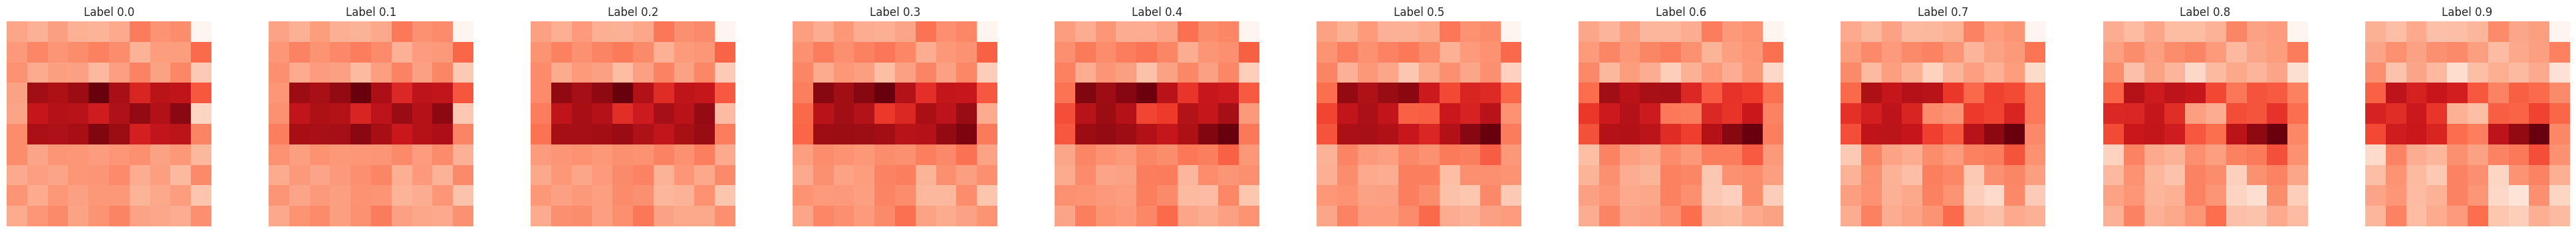

In [ ]:
steps = 10
fig, axs = plt.subplots(1, steps, figsize=(5 * steps, 4))
with torch.no_grad():
    for i in range(steps):
        label = torch.tensor([i / steps], device=device)
        axs[i].imshow(flow(label).sample((1000,)).mean(dim=0).cpu().numpy().reshape(ny_coarse, nx_coarse), cmap="Reds")
        axs[i].set_title(f"Label {i / steps}")
        axs[i].axis("off")
